In [1]:
from google.cloud import bigquery
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
plt.style.use('ggplot')

# Create a BigQuery client
client = bigquery.Client.from_service_account_json("key.json")

In [19]:
class Stock:
    query = """
SELECT * FROM `cse-6242-fa24-lz.stock_prices_data.stock_price_history`
"""
    stock_raw = (client.query(query)
                        .to_dataframe()
                        .sort_values(by='date')
                        .reset_index(drop=True))
class StockSel(Stock):
    def __init__(self,ticker):
        self.ticker = ticker
        self.col_name = '_close_{}x'.format(ticker)
        assert self.col_name in self.stock_raw.columns, "ticker not found"
        self.stock_sel = self.stock_raw[['date', self.col_name]]
        self.stock_sel['5_day_avg_prior'] = self.stock_sel['_close_{}x'.format(self.ticker)].rolling(window=6, min_periods=1).mean().shift(1)
        self.stock_sel['10_day_avg_prior'] = self.stock_sel['_close_{}x'.format(self.ticker)].rolling(window=11, min_periods=1).mean().shift(1)
        self.get_active_month_close()
        self.get_inactive_avg()
        self.get_rel_monthly_close()
        self.get_active_week_close()
        self.get_rel_weekly_close()
    def get_active_month_close(self):
        # get the close value on the last available day of each month
        self.active_month_close = self.stock_sel.groupby([self.stock_sel['date'].dt.year, self.stock_sel['date'].dt.month]).tail(1)
        self.active_month_close = self.active_month_close[self.active_month_close['date'].dt.month.isin(range(6, 12))].reset_index(drop=True)
    def get_active_week_close(self):
        # Filter the data to include only dates from June to November
        self.active_week_close = self.stock_sel[
            self.stock_sel['date'].dt.month.isin(range(6, 12))
        ].copy()

        # Set the date as the index for resampling
        self.active_week_close.set_index('date', inplace=True)

        # Resample by week and take the last available close price for each week
        self.active_week_close = (
            self.active_week_close.resample('W').last().reset_index()
        )
        
        # Reset index for convenience
        self.active_week_close.reset_index(drop=True, inplace=True)
    def get_inactive_avg(self):
        # get the average stock price from days in inactive months
        self.inactive_months = self.stock_sel[~self.stock_sel['date'].dt.month.isin(range(6, 12))]
        self.inactive_months['year'] = self.inactive_months['date'].dt.year
        self.inactive_year_avg = (self.inactive_months.groupby('year')[self.col_name]
                                                    .mean()
                                                    .reset_index())
    def get_rel_monthly_close(self):
        # get the reletive stock price
        self.active_month_close['year'] = self.active_month_close['date'].dt.year
        self.stock_month_merged = self.active_month_close.merge(
                        self.inactive_year_avg,
                        on = 'year', suffixes=('','_yr')
                        )
        self.stock_month_merged['rel_close'] = self.stock_month_merged[self.col_name] / \
                                                        self.stock_month_merged[self.col_name+'_yr']
        self.rel_stock_monthly = self.stock_month_merged[['date','rel_close']]
    def get_rel_weekly_close(self):
        # get the reletive stock price
        self.active_week_close['year'] = self.active_week_close['date'].dt.year
        self.stock_week_merged = self.active_week_close.merge(
                        self.inactive_year_avg,
                        on = 'year', suffixes=('','_yr')
                        )
        self.stock_week_merged['rel_close'] = self.stock_week_merged[self.col_name] / \
                                                        self.stock_week_merged[self.col_name+'_yr']
        self.rel_stock_weekly = self.stock_week_merged[['date','rel_close']]
        

/home/chen112p/.pyenv/versions/3.12.4/lib/python3.12/site-packages/google/cloud/bigquery/table.py:1727: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


In [20]:
home_depot = StockSel(ticker='hd')
lowes = StockSel(ticker='low')
spy = StockSel(ticker='spy')

/tmp/ipykernel_380984/1395355531.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.stock_sel['5_day_avg_prior'] = self.stock_sel['_close_{}x'.format(self.ticker)].rolling(window=6, min_periods=1).mean().shift(1)
/tmp/ipykernel_380984/1395355531.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.stock_sel['10_day_avg_prior'] = self.stock_sel['_close_{}x'.format(self.ticker)].rolling(window=11, min_periods=1).mean().shift(1)
/tmp/ipykernel_380984/1395355531.py:45: SettingWithCopyWarning: 
A val

In [23]:
home_depot.active_month_close

,date,_close_hdx,5_day_avg_prior,10_day_avg_prior,year
0,2013-11-29 00:00:00+00:00,80.669998,79.920001,79.649091,2013
1,2014-06-30 00:00:00+00:00,80.959999,80.608332,80.162727,2014
2,2014-07-31 00:00:00+00:00,80.849998,81.176666,80.600001,2014
3,2014-08-29 00:00:00+00:00,93.500000,91.565000,89.046364,2014
4,2014-09-30 00:00:00+00:00,91.739998,92.336665,91.756362,2014
...,...,...,...,...,...
62,2024-07-31 00:00:00+00:00,368.160004,358.015004,361.980910,2024
63,2024-08-30 00:00:00+00:00,368.500000,371.331660,368.265450,2024
64,2024-09-30 00:00:00+00:00,405.200012,395.939997,390.475453,2024
65,2024-10-31 00:00:00+00:00,393.750000,398.618337,404.470001,2024


In [24]:
out_csv = pd.DataFrame({
    'date': home_depot.rel_stock_monthly['date'].dt.strftime('%Y-%m'),
    'hd_rel_close': home_depot.rel_stock_monthly['rel_close'],
    'hd_close': home_depot.active_month_close['_close_hdx'],
    'hd_5days_avg': home_depot.active_month_close['5_day_avg_prior'],
    'hd_10day_avg': home_depot.active_month_close['10_day_avg_prior'],
    'hd_rel_close_diff': home_depot.rel_stock_monthly['rel_close'] - \
                        spy.rel_stock_monthly['rel_close'],
    'hd_close_diff': home_depot.active_month_close['_close_hdx'] / \
                        spy.active_month_close['_close_spyx'],
    'lowes_rel_close': lowes.rel_stock_monthly['rel_close'],
    'lowes_close': lowes.active_month_close['_close_lowx'],
    'lowes_5days_avg': lowes.active_month_close['5_day_avg_prior'],
    'lowes_10day_avg': lowes.active_month_close['10_day_avg_prior'],
    'lowes_rel_close_diff': lowes.rel_stock_monthly['rel_close'] - \
                        spy.rel_stock_monthly['rel_close'],
    'lowes_close_diff': lowes.active_month_close['_close_lowx'] / \
                        spy.active_month_close['_close_spyx'],
})


In [25]:
out_csv.to_csv('stock_price.csv',index=None)

In [24]:
spy.rel_stock_monthly

,date,rel_close
0,2013-11-29 00:00:00+00:00,0.999921
1,2014-06-30 00:00:00+00:00,1.036465
2,2014-07-31 00:00:00+00:00,1.022537
3,2014-08-29 00:00:00+00:00,1.062890
4,2014-09-30 00:00:00+00:00,1.043349
...,...,...
62,2024-07-31 00:00:00+00:00,1.089724
63,2024-08-30 00:00:00+00:00,1.115186
64,2024-09-30 00:00:00+00:00,1.135129
65,2024-10-31 00:00:00+00:00,1.124999


In [15]:
home_depot.active_month_close

,date,_close_hdx,year
0,2013-11-29 00:00:00+00:00,80.669998,2013
1,2014-06-30 00:00:00+00:00,80.959999,2014
2,2014-07-31 00:00:00+00:00,80.849998,2014
3,2014-08-29 00:00:00+00:00,93.500000,2014
4,2014-09-30 00:00:00+00:00,91.739998,2014
...,...,...,...
62,2024-07-31 00:00:00+00:00,368.160004,2024
63,2024-08-30 00:00:00+00:00,368.500000,2024
64,2024-09-30 00:00:00+00:00,405.200012,2024
65,2024-10-31 00:00:00+00:00,393.750000,2024


In [13]:
merged_df = pd.merge(home_depot.rel_stock_monthly, 
                     lowes.rel_stock_monthly, 
                     left_on='date',
                     right_on='date',
                      how='left')

In [14]:
merged_df

,date,rel_close_x,rel_close_y
0,2013-11-29 00:00:00+00:00,1.010516,0.993672
1,2014-06-30 00:00:00+00:00,0.977168,0.943928
2,2014-07-31 00:00:00+00:00,0.975840,0.941175
3,2014-08-29 00:00:00+00:00,1.128523,1.032833
4,2014-09-30 00:00:00+00:00,1.107280,1.040898
...,...,...,...
62,2024-07-31 00:00:00+00:00,1.036515,1.066099
63,2024-08-30 00:00:00+00:00,1.037472,1.079083
64,2024-09-30 00:00:00+00:00,1.140797,1.176135
65,2024-10-31 00:00:00+00:00,1.108561,1.136967


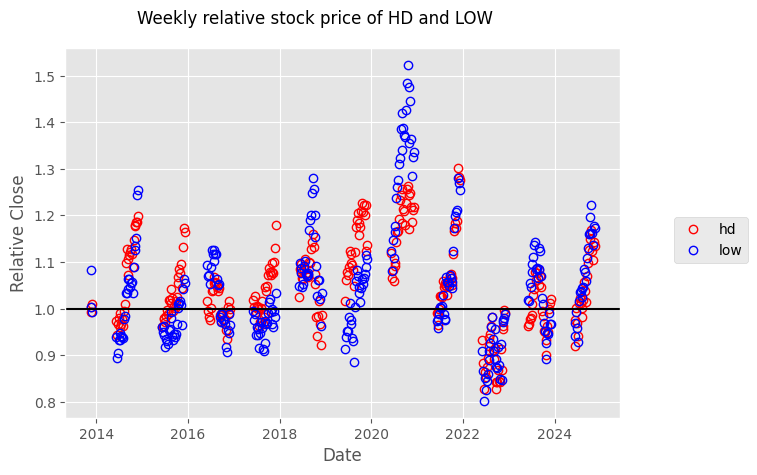

In [7]:
color_list = ['r','b','m','g']
obj_list = [home_depot,
            lowes,
            ]
f,ax = plt.subplots(1,1)
for i,obj in enumerate(obj_list):
    ax.plot(obj.rel_stock_weekly['date'], 
                obj.rel_stock_weekly['rel_close'], 
                '{}o'.format(color_list[i]), mfc='none',label=obj.ticker)

ax.axhline(y=1,color='k')
ax.set_xlabel('Date')
ax.set_ylabel('Relative Close')

f.suptitle('Weekly relative stock price of HD and LOW')
f.legend(loc='center left', bbox_to_anchor=(1.05, 0.5))
f.tight_layout()


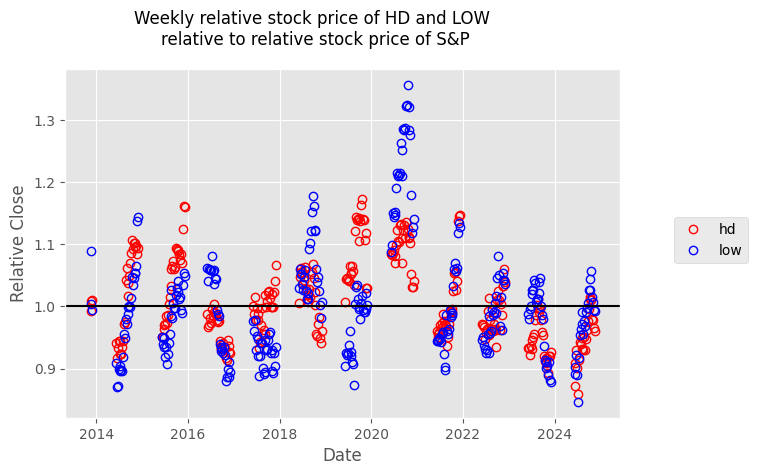

In [8]:
color_list = ['r','b','m','g']
obj_list = [home_depot,
            lowes,
            ]
f,ax = plt.subplots(1,1)
for i,obj in enumerate(obj_list):
    ax.plot(obj.rel_stock_weekly['date'], 
                obj.rel_stock_weekly['rel_close'] / spy.rel_stock_weekly['rel_close'], 
                '{}o'.format(color_list[i]), mfc='none',label=obj.ticker)

ax.axhline(y=1,color='k')
ax.set_xlabel('Date')
ax.set_ylabel('Relative Close')

f.suptitle('Weekly relative stock price of HD and LOW \nrelative to relative stock price of S&P')
f.legend(loc='center left', bbox_to_anchor=(1.05, 0.5))
f.tight_layout()